# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

### Libraries

In [24]:
from os import path, getcwd, listdir

import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew, shapiro, normaltest, kstest, norm, t
from statistics import stdev

from IPython.display import FileLink, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

### Pathing and Data

In [2]:
#WDir
LOCAL_DIR = getcwd()
print(LOCAL_DIR)

hbt_path = path.join(LOCAL_DIR, 'human_body_temperature.csv')

#Import Data
df = pd.read_csv(hbt_path)

/mnt/cephfs/hadoop-compute/phoenix/jeff.anglin/practice/springboard/tempa


### UDF's

In [3]:
#Exploration
def display_all(df,max_rows=1000,max_columns=1000):
    """Display a data frame within a pandas option context.
    """
    with pd.option_context("display.max_rows", max_rows, "display.max_columns", max_columns):
        display(df)
        
def view(data, sample_size=5, max_rows=1000, max_columns=1000):
    """Display the shape and sample of observations for a dataset.
    """
    print("DF shape: {shp}".format(shp=df.shape))
    with pd.option_context("display.max_rows",max_rows, "display.max_columns", max_columns):
        display(Markdown('##### DF Sample \n({sple} Observations)'.format(sple=sample_size)))
        display(data.sample(sample_size))
    display(data.dtypes)
    
    
def expHist(x,title):
    mn = np.mean(x)
    sdev = np.std(x)
    _ = plt.hist(x)
    #mean
    _ = plt.axvline(mn,linestyle='-', color='black', alpha=0.8)
    #s1
    _ = plt.axvline(mn-sdev, linestyle='-', color='black', alpha = 0.65)
    _ = plt.axvline(mn+sdev, linestyle='-', color='black', alpha = 0.65)
    #s2
    _ = plt.axvline(mn-sdev*2, linestyle='--', color='black', alpha = 0.50)
    _ = plt.axvline(mn+sdev*2, linestyle='--', color='black', alpha = 0.50)
    #s3
    _ = plt.axvline(mn-sdev*3, linestyle='-.', color='black', alpha = 0.25)
    _ = plt.axvline(mn+sdev*3, linestyle='-.', color='black', alpha = 0.25)

    _ = plt.xlabel(title)
    display(Markdown('#### {ttl}'.format(ttl=title)))
    plt.show()
    

def ks_plot_norm(data):
    length = len(data)
    plt.figure(figsize=(12, 7))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False))
    plt.plot(np.sort(norm.rvs(loc=np.mean(data), scale=np.std(data), size=len(data))), np.linspace(0, 1, len(data), endpoint=False))
    plt.legend('top right')
    plt.legend(['Data', 'Theoretical Values'])
    plt.title('Comparing CDFs for KS-Test')

## 1. Is the distribution of body temperatures normal?

1. Is the distribution of body temperatures normal?
  - Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
  - Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test

In [4]:
view(df)
display(df.describe())

DF shape: (130, 3)


##### DF Sample 
(5 Observations)

,temperature,gender,heart_rate
117,97.8,F,71.0
24,97.8,M,65.0
119,98.4,F,74.0
36,99.1,M,71.0
65,97.4,M,70.0


temperature    float64
gender          object
heart_rate     float64
dtype: object

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


#### Body Temperature

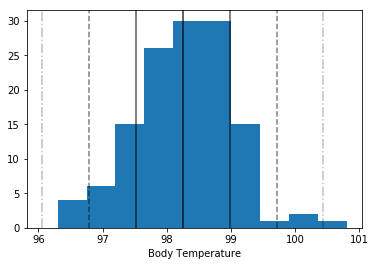

#### Heart Rate

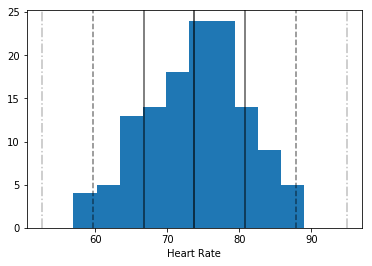

In [5]:
expHist(df.temperature, title="Body Temperature")

expHist(df.heart_rate, title="Heart Rate")

#### Skewness: -0.004 | Kurtosis: 0.705

### D'Agostino test:

#### Stat: 2.703801433319203 | P: 0.2587479863488254 | Alpha: 0.05

### Shapiro-Wilk

#### Stat: 0.9865770936012268 | P: 0.233174666762352 | Alpha: 0.05

### Kolmogorov-Smirnov

#### Stat: 0.06385348427883908 | P: 0.6645320172840667 | Alpha: 0.05

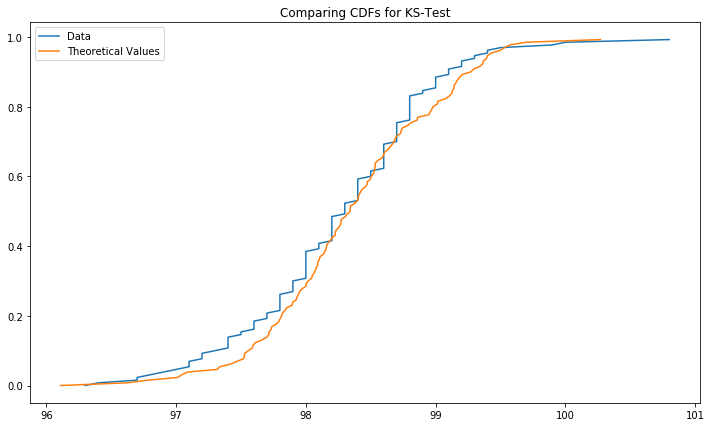

In [6]:
#Normality Test
display(Markdown('#### Skewness: {sk} | Kurtosis: {ku}'.format(sk=round(skew(df.temperature),3), ku=round(kurtosis(df.temperature),3))))

#D'Agostino
stat,p = normaltest(df.temperature)
display(Markdown("### D'Agostino test:"))
display(Markdown('#### Stat: {st} | P: {p} | Alpha: {a}'.format(st=stat,p=p,a=0.05)))

#Shapiro-Wilk
stat, p = shapiro(df.temperature)
display(Markdown('### Shapiro-Wilk'))
display(Markdown('#### Stat: {st} | P: {p} | Alpha: {a}'.format(st=stat,p=p,a=0.05)))

#KS
stat, p = kstest(df.temperature, 'norm', args=(np.mean(df.temperature),np.std(df.temperature)))
display(Markdown('### Kolmogorov-Smirnov'))
display(Markdown('#### Stat: {st} | P: {p} | Alpha: {a}'.format(st=stat,p=p,a=0.05)))
ks_plot_norm(df.temperature)

In [7]:
#QQ plot

Is the distribution of body temperature normal? __**Yes**__

## 2. Is the sample size large? Are the observations independent?

Is the sample size large? Are the observations independent?
  - Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.

In [8]:
def largeEnough(x):
    if len(x) >= 30:
        lgSample = True
    else:
        lgSample = False
    return lgSample

print('Is sample data set large enought? {lg}'.format(lg=largeEnough(df)))

Is sample data set large enought? True


## 3. Is the true population mean really 98.6 degrees F?

- First, try a bootstrap hypothesis test.
- Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
- In this situation, is it appropriate to use the  tt  or  zz  statistic? 
    - If dataset has a normal distribution
    - Ttest used for smaller samples.
- Now try using the other test. How is the result be different? Why?

In [9]:
H0 = 98.6
sm = np.mean(df.temperature)
print(sm)

98.24923076923078


### Bootstrap Hypothess Test

#### Bootstrapped Means

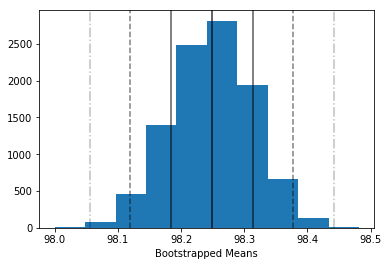

95% confidence interval = [96.7 99.5] Temperatures


In [10]:
#bootstrap hypothesis test
def bootstrap(x,samples=10000):
    """Return a list of bootstrapped samples."""
    n = len(x)
    bt_straps = [np.random.choice(x,size=n) for i in range(samples)]
    return(bt_straps)

temp_bts = bootstrap(df.temperature)
bt_means = [np.mean(i) for i in temp_bts]
expHist(bt_means, "Bootstrapped Means")

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(temp_bts,[2.5,97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'Temperatures')

### Frequentist Approach
This is a two-sample test, since it is measuring the difference between 98.6 (H0) and the sample mean, 98.2.

In [11]:
#frequentist statistical testing. one-sample or two-sample?
ci = 0.95
alpha = 0.05
smean = np.mean(df.temperature)
sstd = stdev(df.temperature)

def ttest(x, hyp):
    """Uses sample standard deviation."""
    smean = np.mean(x)
    sstd = stdev(x)
    t = (smean - hyp)/(sstd/np.sqrt(len(x)))
    return(t)
    
tvalue = ttest(df.temperature, 98.6)
print('T Value: ',tvalue)

T Value:  -5.454823292364077


With 129 Degrees of Freedom, this t statistic results in a power of < 0.1%

In [12]:
#Other test different? why?
def ztest(x,hyp):
    """Uses population standard deviation."""
    smean = np.mean(x)
    sstd = np.std(x)
    z = (smean - hyp)/(sstd)
    return(z)
    
    
zvalue = ztest(df.temperature, 98.6)
print('Z Value: ',zvalue)

Z Value:  -0.48027041116080765


Z-Table Results: 32%

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

- Which one is the correct one to use?
- What do you notice? What does this tell you about the difference in application of the  tt  and  zz  statistic?

In [13]:
sam_n = 10
sample = df.temperature.sample(sam_n)

In [14]:
display(sample)

39     96.4
34     99.3
74     99.0
16     98.3
76     98.0
115    98.0
80     98.8
29     98.1
52     98.5
23     98.4
Name: temperature, dtype: float64

In [15]:
tvalue = ttest(sample, 98.6)
print('T Value: ',tvalue)

zvalue = ztest(sample, 98.6)
print('Z Value: ',zvalue)

T Value:  -1.2810252304406728
Z Value:  -0.42700841014689095


T Test: < 10%

Z Test: 32%

## 5. Is there a significant difference between males and females in normal temperature?

- What testing approach did you use and why?
- Write a story with your conclusion in the context of the original problem.

In [27]:
#display(df.head(1))

In [28]:
m = df.loc[df.loc[:,'gender']=='M','temperature']
print('Average Male Temp: ', np.mean(m))
f = df.loc[df.loc[:,'gender']=='F','temperature']
print('Average Female Temp: ', np.mean(f))

#for s in [m,f]:
#    display(s.head(3))

Average Male Temp:  98.1046153846154
Average Female Temp:  98.39384615384613


### Two Sample Test
- Null Hypothesis: m1 - m2 = 0

- Alternative Hyothesis: m1 - m2 != 0

- Significance Lvl: 0.05


In [21]:
def degFree(x1, x2):
    n1 = len(x1)
    s1 = np.std(x1)
    n2 = len(x2)
    s2 = np.std(x2)
    numer = (s1**2/n1 + s2**2/n2)**2
    denom = (s1**2/n1)**2 / (n1 - 1) + (s2**2/n2)**2/(n2-1)
    v = numer / denom
    return(v)

dfree = degFree(m,f)
print('Degrees of Freedom: ',round(dfree))

Degrees of Freedom:  128


In [22]:
def tTest2(x1,x2):
    m1 = np.mean(x1)
    s1 = np.std(x1)
    n1 = len(x1)
    m2 = np.mean(x2)
    s2 = np.std(x2)
    n2 = len(x2)
    numer = (m1 - m2)
    denom = np.sqrt(s1**2/n1 + s2**2/n2)
    t = numer/denom
    return(t)

tvalue = tTest2(m,f)
print('T Value: ',tvalue)

T Value:  -2.3032202891940123


In [25]:
p = 1 - t.cdf(tvalue,df=dfree)
print('P Value: ',p)

P Value:  0.9885572293138852


## The Difference in Mean Body Temperature by Gender

From a sample of 130 observations, it was determined that men and women have statistically different mean body temperatures. Women have an average temperature of 98.4 degrees (F) while men have an average temperature of 98.1. 

Both are quite different than the average (98.6) proposed by Wunderlich in 1868.